In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import OrderedDict

from modules import Net, Channel

In [82]:
n_batches = 100
batch_size = 128
n_bits = 128
code_len = 256
        
mid_dim = 1024
encoder = Net(n_bits, mid_dim, code_len, 1, 'all', True).cuda()
decoder = Net(code_len, mid_dim, n_bits, 1, 'all', False).cuda()
channel = Channel(1.0).cuda()

params = [p for p in encoder.parameters()] + [p for p in decoder.parameters()]

In [83]:
encoder

Net(
  (layers): Sequential(
    (fc0): Linear(in_features=128, out_features=256)
    (bn0): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True)
  )
)

18
27
52
0.844002075195
CPU times: user 26.6 s, sys: 368 ms, total: 26.9 s
Wall time: 26.7 s


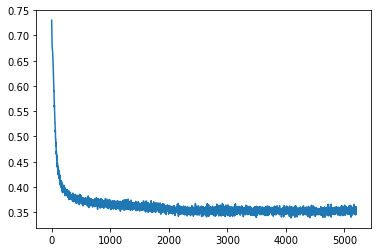

In [84]:
%%time

encoder.train()
decoder.train()

n_stops = 0
n_stale_epochs = 0
n_epochs = 0
optimizer = optim.SGD(params, lr=10.0, momentum=0.9)
losses = []

while n_stops < 3:

    all_data = (torch.rand((n_batches, batch_size, n_bits)) > 0.5).type(torch.FloatTensor)
    n_correct = 0

    for data in all_data:
        optimizer.zero_grad()
        data = Variable(data.cuda())
        message = encoder(data)
        corrupted = channel(message)
        reconstruction = decoder(corrupted)
        loss = F.binary_cross_entropy_with_logits(reconstruction, data)
        loss.backward()
        optimizer.step()

        n_correct += torch.sum(((reconstruction > 0).type(torch.cuda.FloatTensor) == data).type(torch.cuda.FloatTensor))
        losses.append(loss.data[0])
        
    n_epochs += 1
    
    if losses[-n_batches] - np.std(losses[-n_batches:]) < losses[-1]:
        n_stale_epochs += 1
    else:
        n_stale_epochs = 0
        
    if n_stale_epochs > 5:
        n_stale_epochs = 0
        n_stops += 1
        optimizer.param_groups[0]['lr'] *= 0.1
        print n_epochs
    
plt.plot(losses)

print float(n_correct) / all_data.nelement()

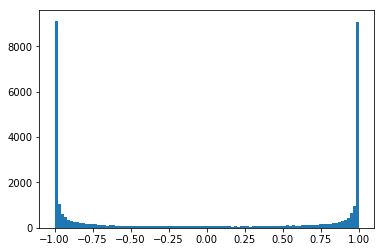

In [80]:
plt.hist(message.data.cpu().numpy().ravel(), bins=100)
plt.show()

# Testing

In [70]:
all_data = (torch.rand((1000, batch_size, n_bits)) > 0.5).type(torch.FloatTensor)
n_correct = 0
for data in all_data:
    data = Variable(data.cuda())
    message = encoder(data)
    message.data[message.data > 0] = 1
    message.data[message.data < 0] = -1
    corrupted = channel(message)
    reconstruction = decoder(corrupted) 
    n_correct += torch.sum(((reconstruction > 0).type(torch.cuda.FloatTensor) == data).type(torch.cuda.FloatTensor))
print 'bitwise accuaracy = %f' % (float(n_correct) / all_data.nelement())

bitwise accuaracy = 0.875126


# Explore trained codes

In [9]:
data = torch.zeros(2**n_bits, n_bits)
for i in range(2**n_bits):
    code = np.binary_repr(i, width=n_bits)
    for j in range(n_bits):
        data[i, j] = float(code[j])
data = Variable(data.cuda())

In [10]:
data

Variable containing:
    0     0     0     0
    0     0     0     1
    0     0     1     0
    0     0     1     1
    0     1     0     0
    0     1     0     1
    0     1     1     0
    0     1     1     1
    1     0     0     0
    1     0     0     1
    1     0     1     0
    1     0     1     1
    1     1     0     0
    1     1     0     1
    1     1     1     0
    1     1     1     1
[torch.cuda.FloatTensor of size 16x4 (GPU 0)]

In [11]:
message = encoder(data)

In [12]:
message

Variable containing:
 0.9999  0.9996  0.9995 -0.9996 -0.9998  0.9999 -0.9998  0.9999
 0.9999  0.9998  1.0000  1.0000 -1.0000  0.9999 -0.9999 -1.0000
 0.9999  0.9998  0.9999 -1.0000  1.0000  0.9999  0.9998  0.9998
 0.9999  0.9999  1.0000  0.9999  1.0000  0.9999  0.9999 -1.0000
 0.9999  0.9998 -1.0000 -0.9999 -1.0000 -0.9998 -0.9999  1.0000
 0.9999  0.9999 -0.9999  1.0000 -1.0000 -0.9999 -0.9999 -1.0000
 0.9999  0.9999 -1.0000 -1.0000  1.0000 -0.9999  0.9998  0.9999
 1.0000  1.0000 -0.9999  0.9998  0.9998 -1.0000  0.9999 -1.0000
-0.9999 -0.9999  0.9997 -0.9997 -0.9998  1.0000 -0.9999  1.0000
-0.9999 -0.9998  1.0000  1.0000 -1.0000  0.9999 -0.9999 -0.9999
-0.9999 -0.9999  0.9999 -1.0000  1.0000  0.9999  0.9999  1.0000
-1.0000 -0.9999  1.0000  0.9999  1.0000  0.9999  0.9999 -1.0000
-0.9999 -0.9999 -1.0000 -0.9999 -1.0000 -0.9999 -0.9999  1.0000
-0.9999 -0.9999 -0.9999  1.0000 -1.0000 -1.0000 -0.9999 -0.9999
-1.0000 -0.9999 -1.0000 -1.0000  1.0000 -0.9999  0.9999  1.0000
-1.0000 -0.9999 -0.

In [13]:
b = message.clone().data
b[b > 0] = 1.0
b[b < 0] = 0
print b


    1     1     1     0     0     1     0     1
    1     1     1     1     0     1     0     0
    1     1     1     0     1     1     1     1
    1     1     1     1     1     1     1     0
    1     1     0     0     0     0     0     1
    1     1     0     1     0     0     0     0
    1     1     0     0     1     0     1     1
    1     1     0     1     1     0     1     0
    0     0     1     0     0     1     0     1
    0     0     1     1     0     1     0     0
    0     0     1     0     1     1     1     1
    0     0     1     1     1     1     1     0
    0     0     0     0     0     0     0     1
    0     0     0     1     0     0     0     0
    0     0     0     0     1     0     1     1
    0     0     0     1     1     0     1     0
[torch.cuda.FloatTensor of size 16x8 (GPU 0)]



# Shannon limit

In [33]:
nn_rate=np.array([0.66, 0.5, 0.4, 0.25])
nn_acc=np.array([0.8511, 0.9122, 0.9336, 0.9543])

In [34]:
from scipy.integrate import quad as integrate
def phi(y, sigma):
    return 1. / np.sqrt(8*np.pi*sigma**2) * (np.exp(-(y-1)**2/(2*sigma**2)) + np.exp(-(y+1)**2/(2*sigma**2)))
def capacity(sigma):
    lim = 5.0
    A, A_err = integrate(lambda y: phi(y, sigma) * np.log2(phi(y, sigma)), -lim, lim)
    B = 0.5 * np.log2(2*np.pi*np.e*sigma**2)
    #print sigma, -A, -B
    #B = 0.5 * (np.log2(2*np.pi*sigma**2) + 1)
    #print A_err
    return -A - B
#sigma = np.linspace(0, 2, 21)[1:]
#C = [capacity(s) for s in sigma]
#plt.plot(sigma, C)

print capacity(1.)

0.485461483231


In [35]:
nn_rate=np.array([0.66, 0.5, 0.4, 0.25])
nn_acc=np.array([0.8511, 0.9122, 0.9336, 0.9543])

def h(p):
    return -p*np.log2(p) - (1-p)*np.log2(1-p)

def shannon_rate(sigma, error):
    return capacity(sigma) / (1 - h(error))

In [52]:
1-np.array([0.9025, 0.9314, 0.9687])

array([ 0.0975,  0.0686,  0.0313])

[]

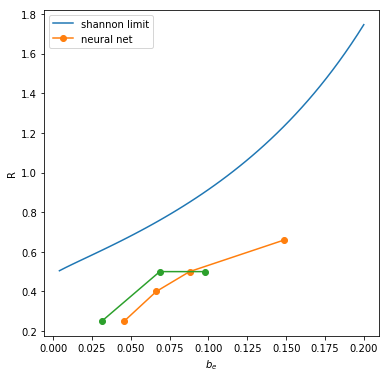

In [54]:
plt.figure(figsize=(6,6))
b = np.linspace(0, 0.2, 51)[1:]
C = [capacity(1.0) / (1-h(x)) for x in b]
plt.plot(b, C)
nn_rate=np.array([0.66, 0.5, 0.4, 0.25])
nn_acc=np.array([0.8511, 0.9122, 0.9336, 0.9543])
plt.plot(1-nn_acc, nn_rate, '-o')
nn_acc = np.array([0.9025, 0.9314, 0.9687])
plt.plot(1-np.array([0.9025, 0.9314, 0.9687]), np.array([0.5, 0.5, 0.25]), '-o')
plt.legend(('shannon limit', 'neural net'))
plt.ylabel('R')
plt.xlabel('$b_e$')
plt.plot()

In [103]:
capacity(1.)

0.48546148323050975

In [4]:
import json, os

In [35]:
json.load?

In [5]:
accuracy = np.zeros((3, 3, 5, 4, 5))

for f in os.listdir('logs'):
    filename = 'logs/' + f
    bn, n_layers, mid_dim, lr, n = f.split('_')
    data = json.load(open(filename, 'r'))
    n_layers, mid_dim, lr, n = int(n_layers), int(mid_dim), int(lr), int(n)
    bn = ['all', 'inside', 'no'].index(bn)
    mid_dim = [64, 128, 256, 512, 1024].index(mid_dim)
    n_layers = n_layers-1
    lr = [1, 2, 5, 10].index(lr)
    n = n - 1
    print data['accuracy'], bn, n_layers, mid_dim, lr, n
    accuracy[bn, n_layers, mid_dim, lr, n] = data['accuracy']

0.914145141602 1 0 2 1 0
0.871944091797 0 1 2 3 4
0.515877563477 2 2 4 2 1
0.763864746094 1 2 2 1 4
0.938625610352 0 1 2 0 2
0.950203613281 0 0 1 3 3
0.956415161133 0 0 2 0 1
0.949433837891 0 0 1 2 4
0.958586303711 1 1 4 3 0
0.870159912109 2 1 1 1 4
0.940721557617 2 0 1 3 2
0.941358398438 1 1 3 3 4
0.664737915039 0 2 2 2 1
0.538992553711 2 2 3 2 1
0.500238037109 2 1 1 3 4
0.909634155273 1 0 4 0 2
0.942966064453 1 1 2 1 1
0.704257568359 2 2 4 1 3
0.647211181641 0 2 1 0 1
0.680526611328 1 2 1 2 2
0.821544311523 1 1 0 1 2
0.962148193359 1 0 4 3 1
0.949232177734 0 1 4 1 2
0.740193969727 2 2 3 0 3
0.814029174805 0 1 1 3 0
0.648890625 0 2 2 3 4
0.863177856445 0 1 1 0 0
0.914890869141 1 0 1 1 4
0.499873413086 2 2 2 2 2
0.946065429687 1 1 4 3 2
0.908135009766 1 0 0 0 0
0.799008911133 1 2 4 3 1
0.908965820312 2 0 2 0 3
0.759693969727 1 2 3 0 3
0.763108886719 1 1 0 3 3
0.747174926758 0 2 4 3 0
0.939561767578 0 1 3 1 2
0.49994909668 2 1 3 3 4
0.948541259766 0 1 3 0 0
0.93073046875 2 1 4 0 3
0.670

0.683253173828 1 2 2 1 3
0.641270141602 0 2 1 3 0
0.900962402344 1 0 0 0 1
0.899659545898 2 1 4 2 1
0.715356323242 1 2 1 0 1
0.954006347656 0 0 3 1 4
0.683016113281 1 2 2 2 0
0.915269897461 2 0 1 2 2
0.897864013672 0 1 3 2 1
0.813266479492 2 2 4 0 0
0.95385949707 2 1 2 0 1
0.952454833984 0 0 1 3 2
0.893069213867 1 1 1 2 4
0.640293701172 1 2 0 2 2
0.499844604492 2 1 2 3 4
0.900063110352 1 0 1 0 4
0.917933349609 1 0 3 2 2
0.70237097168 2 2 2 0 1
0.953494506836 1 1 3 2 4
0.917245727539 0 1 4 3 3
0.948498901367 0 1 4 1 1
0.955087280273 0 0 1 1 1
0.966258178711 0 0 3 3 4
0.919157714844 2 0 1 3 0
0.952396484375 0 0 1 0 1
0.922984619141 1 1 2 2 0
0.907614257813 2 0 4 0 3
0.662454467773 1 2 0 3 0
0.499904907227 2 1 2 3 1
0.912871459961 2 0 3 1 2
0.913599487305 2 0 3 2 1
0.678661743164 1 2 1 0 4
0.843508178711 1 2 4 0 1
0.843342651367 1 1 1 3 3
0.818575927734 1 2 4 2 4
0.499801757813 2 2 2 2 0
0.845706542969 2 1 2 2 4
0.907398925781 1 0 4 1 2
0.838315795898 1 1 1 0 1
0.9321796875 2 0 2 3 0
0.61

0.765418945312 2 1 1 2 3
0.910939575195 2 0 2 1 3
0.969925537109 0 0 3 3 3
0.6130390625 2 2 4 3 1
0.956260742188 0 0 1 3 4
0.678641235352 2 2 3 1 0
0.953149414062 1 1 4 2 4
0.919300415039 2 0 2 2 1
0.821328735352 1 2 4 0 0
0.733412963867 1 2 3 3 2
0.908265014648 1 0 3 0 3
0.882450561523 0 1 3 3 2
0.911778320312 1 0 0 1 2
0.668706420898 1 2 0 1 4
0.818865966797 1 2 4 2 1
0.893739501953 2 1 3 2 1
0.921710693359 1 0 2 3 2
0.940536132813 2 1 2 1 1
0.901874145508 1 1 2 3 1
0.704671508789 2 2 4 1 1
0.966438842773 0 0 2 3 3
0.782663208008 0 2 4 2 2
0.955667358398 0 1 4 0 3
0.908168701172 2 0 1 0 2
0.901568237305 2 0 3 0 0
0.734765136719 1 2 3 3 3
0.957748291016 0 0 2 0 4
0.949331787109 2 1 2 0 0
0.930848754883 2 0 2 3 3
0.914038085938 0 1 4 3 1
0.924525268555 2 1 2 1 2
0.525123291016 2 2 2 2 1
0.952311767578 2 0 2 3 1
0.901260009766 1 1 2 3 2
0.944293579102 1 0 1 3 1
0.917016967773 1 0 0 2 1
0.685759765625 1 2 2 3 0
0.792131835938 0 2 3 1 2
0.947093017578 2 1 4 1 3
0.969358764648 0 0 4 1 4
0.

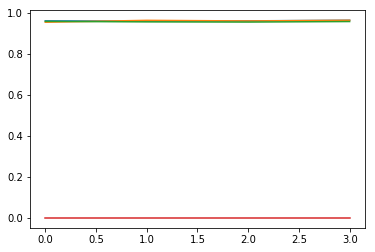

In [6]:
plt.plot(accuracy[0, 0, 3, :].mean(axis=-1))
plt.plot(accuracy[0, 0, 2, :].mean(axis=-1))
plt.plot(accuracy[0, 0, 1, :].mean(axis=-1))
plt.plot(accuracy[0, 0, 0, :].mean(axis=-1))

<Container object of 3 artists>

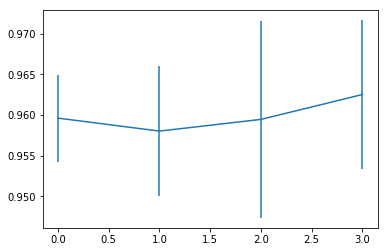

In [7]:
y    = accuracy[0, 0, 3, :].mean(axis=-1)
x    = np.arange(len(y))
yerr = accuracy[0, 0, 3, :].std(axis=-1)
plt.errorbar(x, y, yerr=yerr)

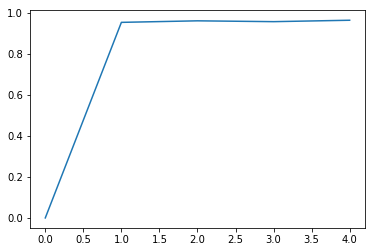

In [8]:
plt.plot(accuracy[0, 0, :, 1].mean(axis=-1))

In [70]:
accuracy.mean(axis=-1).max(), accuracy[0, 0, 3, 1].mean(axis=-1)
#bn, n_layers, mid_dim, lr,
#all 1 1024 2

(0.96489982910156247, 0.96489982910156247)

0.96489982910156247